# Analysis of optogenetic activation experiments with short light pulses
## Comparison across experimental groups

*Experiment*: About 10 flies are placed in the free walking arena and full-field red light stimulation is delivered repeatedly for short periods.
We are looking for changes in the fly's walking velocities that are associated with the optogenetic activation.

In [1]:
from csv import reader
import numpy as np
from sys import path
from scipy import sparse as sps

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib import gridspec

import pandas as pd

import os
from os.path import isfile, sep
from glob import glob

libprefix = '/Users/haberkernh/Documents/code/'

path.insert(1, libprefix + 'optogeneticsWalkingArena/')
from freeWalkingOptoPlotting import myAxisTheme

import seaborn as sns

%matplotlib inline

### Select data

In [164]:
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/OptoFreeWalking/1_Data/RewardTest_Laura/fullFieldPulse/'
genotype = 'MB001B_x_20xCsChrimsonWTB_male_Wuerzburg'

In [165]:
plotSaveDir = baseDir + genotype + sep + 'plots'
try:
    os.mkdir(plotSaveDir)
except OSError:
    print('Analysis folder already exists')

Analysis folder already exists


### Set experiment parameter

In [166]:
maxExpRep = 6
maxPulseRep = 15
starveLevels = ['20h', '18h', '12h', '0h']
stimLevels = ['200ms', '500ms']

numRep = 6
repOrder = ['rep'+str(i+1) for i in range(numRep)]

In [167]:
fps = 20
pre = -1
post = 3
timeAx = np.linspace(pre, post, (post-pre)*fps)

In [168]:
bins = np.linspace(pre, post, 2*(post-pre))
timeBins = np.digitize(timeAx, bins)/2.0 + pre*np.ones(len(timeAx))

bins2 = np.linspace(pre, post, 5*(post-pre))
timeBins2 = np.digitize(timeAx, bins2)/5.0 + pre*np.ones(len(timeAx))

### Make data frame with just averages over all repeats and stimulation protocols

In [169]:
vtav_df = pd.DataFrame(columns=['stim', 'exprep','starved','time','timebins','timebinsf','vt'])

for stim in ['500ms', '200ms']:

    rootDir = baseDir + genotype + sep + stim + sep + 'analysis'
    expGroup = genotype

    datList = [filepath.split(sep)[-1] for filepath in glob(rootDir + sep + '*.csv')]

    vt_datList = []
    vr_datList = []
    for fn in datList:
        if 'vTrans' in fn:
            vt_datList.append(fn)
        elif 'vRot' in fn:
            vr_datList.append(fn)
        else:
            pass
        
    for fi, currFile in enumerate(vt_datList):
        print(currFile)
        exprep = currFile.split('_')[6]

        # load file specifying data to be analysed
        datFile = open(rootDir+sep+currFile, 'r')
        csv_fileList = reader(datFile)

        vtvals = []

        for i, line in enumerate(csv_fileList):
            vtvals.append(line)

        avvals = np.nanmean(np.asarray(vtvals).astype('float'), axis=0)
        curr_df = pd.DataFrame(timeAx, columns=['time'])
        curr_df.insert(0, 'stim',stim)
        curr_df.insert(0, 'timebins',timeBins)
        curr_df.insert(0, 'timebinsf',timeBins2)
        curr_df.insert(1, 'vt',avvals)
        curr_df.insert(3, 'exprep',exprep)
        if '_20h' in currFile:
            curr_df.insert(3, 'starved','20h')
        elif '_18h' in currFile:
            curr_df.insert(3, 'starved','18h')
        elif '_12h' in currFile:
            curr_df.insert(3, 'starved','12h')
        elif '_0h' in currFile:
            curr_df.insert(3, 'starved','0h')
        vtav_df = vtav_df.append(curr_df, ignore_index = True)

MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep1_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep6_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep5_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep3_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep2_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep4_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_200ms_12h_rep4_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_200ms_12h_rep3_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_200ms_12h_rep1_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_200ms_12h_rep6_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_200ms_12h_rep2_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_200ms_12h_rep5_vTrans_triggeredAverage.csv


In [170]:
vtav_df.head()

,exprep,starved,stim,time,timebins,timebinsf,vt
0,rep1,12h,500ms,-1.000000,-0.5,-0.8,1.523333
1,rep1,12h,500ms,-0.949367,-0.5,-0.8,1.574567
2,rep1,12h,500ms,-0.898734,-0.5,-0.8,1.589544
3,rep1,12h,500ms,-0.848101,-0.5,-0.8,1.790313
4,rep1,12h,500ms,-0.797468,-0.5,-0.8,1.783810


Analysis folder already exists


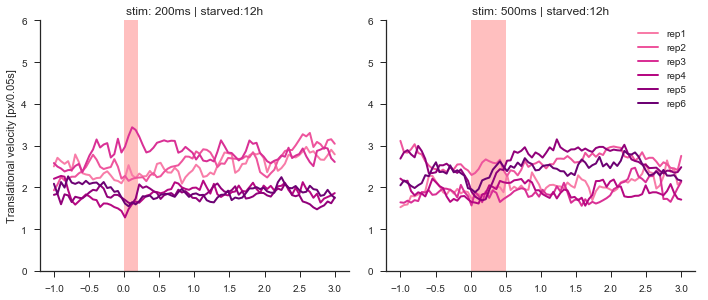

In [179]:
maxExpRep = 6
stimLevels = ['200ms', '500ms']
stimLevelRects = [0.2, 0.5]
repLevels = repOrder
maxY = 6

measuredStarveLevels = []
for starved in starveLevels:
    if not vtav_df.query('starved == "'+starved+'"').empty:
        measuredStarveLevels.append(starved)

fig = plt.figure(figsize=(10,4*max(len(measuredStarveLevels),2)))
for rowind, starved in enumerate(measuredStarveLevels):
    if starved == '0h': colMap = 'PuBu'
    elif 'Control' in genotype or 'control' in genotype: colMap = 'Greens'
    else: colMap = 'RdPu'
    cNorm  = colors.Normalize(vmin=-5, vmax=maxExpRep)
    repCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=colMap)
    
    for colind, stim in enumerate(stimLevels):
        ax = fig.add_subplot(max(len(measuredStarveLevels),2),len(stimLevels),(rowind)*len(stimLevels) + (colind+1))
        for ind, rep in enumerate(repLevels):
            rep_df = vtav_df.query('exprep == "'+rep+'" and stim == "'+stim+'" and starved == "'+starved+'"')
            ax.plot(rep_df['time'].get_values(), rep_df['vt'].get_values(),
                    color=repCMap.to_rgba(ind), linewidth=2)
            ax.set_ylim(0,maxY)
        ax.set_title('stim: '+stim+' | starved:'+starved, fontsize=12)
        if rowind==1: ax.set_xlabel('Time [s]')
        if colind==0: ax.set_ylabel('Translational velocity [px/0.05s]')     
        if colind==1: ax.legend(repLevels, loc=1)
        myAxisTheme(ax)
        
        ax.add_patch(Rectangle((0, 0), stimLevelRects[colind], maxY, facecolor='red', edgecolor='none', lw=1, alpha=0.25))

plotSaveDir = baseDir + genotype + sep + 'plots'
try:
    os.mkdir(plotSaveDir)
except OSError:
    print('Analysis folder already exists')
    
fig.tight_layout()
fig.savefig(plotSaveDir+sep+genotype+'_meanTriggeredAverages.pdf', format = 'pdf')

### Plot with variance across pulse repeats

In [180]:
vt_df = pd.DataFrame(columns=['stim', 'exprep', 'pulserep', 'starved','time','timebins','timebinsf','vt'])
vr_df = pd.DataFrame(columns=['stim', 'exprep', 'pulserep', 'starved','time','timebins','timebinsf','vr'])

for stim in ['500ms', '200ms']:

    rootDir = baseDir + genotype + sep + stim + sep + 'analysis'

    datList = [filepath.split(sep)[-1] for filepath in glob(rootDir + sep + '*.csv')]

    vt_datList = []
    vr_datList = []
    for fn in datList:
        if 'vTrans' in fn:
            vt_datList.append(fn)
        elif 'vRot' in fn:
            vr_datList.append(fn)
        else:
            pass
        
    for fi, currFile in enumerate(vt_datList):
        print(currFile)
        exprep = currFile.split('_')[6]

        # load file specifying data to be analysed
        datFile = open(rootDir+sep+currFile, 'r')
        csv_fileList = reader(datFile)

        vtvals = []

        for i, line in enumerate(csv_fileList):
            curr_df = pd.DataFrame(timeAx, columns=['time'])
            curr_df.insert(0, 'stim',stim)
            curr_df.insert(0, 'timebins',timeBins)
            curr_df.insert(0, 'timebinsf',timeBins2)
            curr_df.insert(1, 'vt',np.asarray(line).astype('float'))
            curr_df.insert(3, 'exprep',exprep)
            curr_df.insert(4, 'pulserep',i+1)
            
            if '_20h' in currFile:
                curr_df.insert(3, 'starved','20h')
            elif '_18h' in currFile:
                curr_df.insert(3, 'starved','18h')
            elif '_12h' in currFile:
                curr_df.insert(3, 'starved','12h')
            elif '_0h' in currFile:
                curr_df.insert(3, 'starved','0h')
            vt_df = vt_df.append(curr_df, ignore_index = True)
        
        
        currFile = vr_datList[fi]
        print(currFile)
        exprep = currFile.split('_')[6]

        # load file specifying data to be analysed
        datFile = open(rootDir+sep+currFile, 'r')
        csv_fileList = reader(datFile)

        for i, line in enumerate(csv_fileList):
            curr_df = pd.DataFrame(timeAx, columns=['time'])
            curr_df.insert(0, 'stim',stim)
            curr_df.insert(0, 'timebins',timeBins)
            curr_df.insert(0, 'timebinsf',timeBins2)
            curr_df.insert(1, 'vr',np.asarray(line).astype('float'))
            curr_df.insert(3, 'exprep',exprep)
            curr_df.insert(4, 'pulserep',i+1)
            
            if '_20h' in currFile:
                curr_df.insert(3, 'starved','20h')
            elif '_18h' in currFile:
                curr_df.insert(3, 'starved','18h')
            elif '_12h' in currFile:
                curr_df.insert(3, 'starved','12h')
            elif '_0h' in currFile:
                curr_df.insert(3, 'starved','0h')
            vr_df = vr_df.append(curr_df, ignore_index = True)
        

MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep1_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep5_vRot_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep6_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep6_vRot_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep5_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep3_vRot_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep3_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep2_vRot_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep2_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep4_vRot_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep4_vTrans_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_500ms_12h_rep1_vRot_triggeredAverage.csv
MB001B_x_20xCsChrimsonWTB_Wuerzburg_200ms_12h_rep4_vTrans_trigge

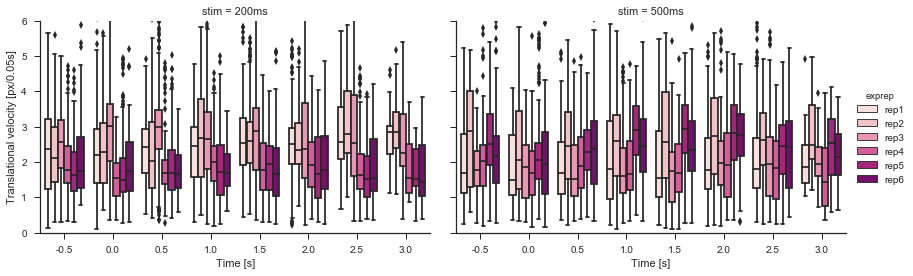

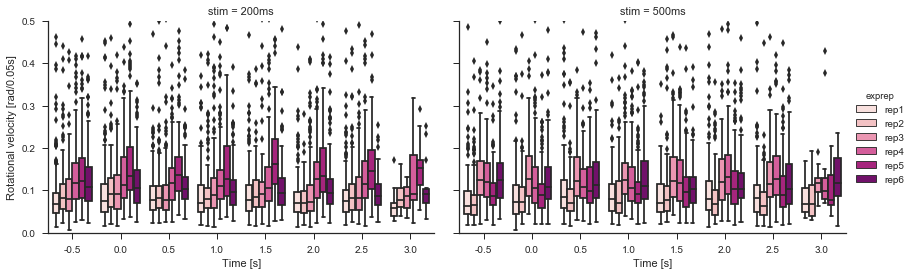

In [181]:
groups = [('fed', '0h'),('starved12h', '12h'),('starved18h', '18h'),('starved20h', '20h')]
colorpal = [sns.color_palette("GnBu"), sns.cubehelix_palette(6), sns.cubehelix_palette(6),sns.cubehelix_palette(6)]

for ind, group in enumerate(groups):
    bp_vt_df = vt_df.query('starved == "'+group[1]+'"')
    bp_vr_df = vr_df.query('starved == "'+group[1]+'"')
    sns.set(style="ticks", color_codes=False)
    
    if group[1] == '0h': colMap = 'PuBu'
    elif 'Control' in genotype or 'control' in genotype: colMap = 'Greens'
    else: colMap = 'RdPu'

    if not bp_vt_df.empty:
        bp = sns.factorplot(data=bp_vt_df, x="timebins", y="vt", hue="exprep",
                            hue_order=repOrder, col="stim",col_order=stimLevels,
                            palette=colMap, kind='box', aspect=1.5)
        plt.ylim(0, 6)
        bp.set_axis_labels("Time [s]", "Translational velocity [px/0.05s]")
        bp.savefig(plotSaveDir+sep+genotype+'_'+group[0]+'_vTrans_boxplot.pdf', format = 'pdf')

    if not bp_vr_df.empty:
        bp = sns.factorplot(data=bp_vr_df, x="timebins", y="vr", hue="exprep",
                            hue_order=repOrder, col="stim",col_order=stimLevels,
                            palette=colMap, kind='box', aspect=1.5)
        plt.ylim(0, 0.5)
        bp.set_axis_labels("Time [s]", "Rotational velocity [rad/0.05s]")
        bp.savefig(plotSaveDir+sep+genotype+'_'+group[0]+'_vRot_boxplot.pdf', format = 'pdf')

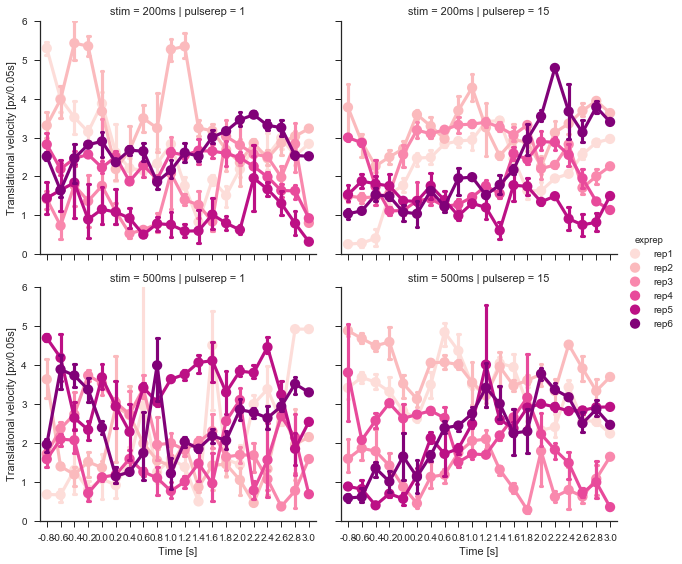

In [182]:
groups = [('fed', '0h'),('starved12h', '12h'),('starved18h', '18h'),('starved20h', '20h')]
colorpal = [sns.color_palette("GnBu"), sns.cubehelix_palette(6), sns.cubehelix_palette(6),sns.cubehelix_palette(6)]

for ind, group in enumerate(groups):
    sns.set(style="ticks", color_codes=False)
    pulse_df = vt_df.query('(pulserep == 1 or pulserep == 15) and (starved == "'+group[1]+'")')
    
    if group[1] == '0h': colMap = 'PuBu'
    elif 'Control' in genotype or 'control' in genotype: colMap = 'Greens'
    else: colMap = 'RdPu'
    
    if not pulse_df.empty:
        g = sns.factorplot(x="timebinsf", y="vt", hue="exprep", col="pulserep",row="stim", data=pulse_df,
                           hue_order=repOrder, row_order=stimLevels,
                           capsize=.2, palette=colMap, size=4, aspect=1.1)
        g.set_axis_labels("Time [s]", "Translational velocity [px/0.05s]")
        plt.ylim(0, 6)
        g.savefig(plotSaveDir+sep+genotype+'_'+group[0]+'_pulseComp.pdf', format = 'pdf')

Analysis folder already exists


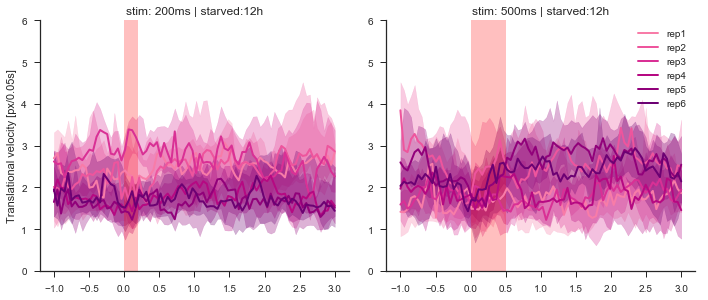

In [184]:
stimLevelRects = [0.2, 0.5]
maxY = 6
repLevels = ['rep'+str(repn) for repn in range(1,maxExpRep+1)]

fig = plt.figure(figsize=(10,4*max(len(measuredStarveLevels),2)))

measuredStarveLevels = []
for starved in starveLevels:
    if not vtav_df.query('starved == "'+starved+'"').empty:
        measuredStarveLevels.append(starved)

for rowind, starved in enumerate(measuredStarveLevels):
    
    if starved == '0h': colMap = 'PuBu'
    elif 'Control' in genotype or 'control' in genotype: colMap = 'Greens'
    else: colMap = 'RdPu'
    cNorm  = colors.Normalize(vmin=-5, vmax=maxExpRep)
    repCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=colMap)
    
    for colind, stim in enumerate(stimLevels):
        ax = fig.add_subplot(max(len(measuredStarveLevels),2),len(stimLevels),(rowind)*len(stimLevels) + (colind+1))
        for ind, rep in enumerate(repLevels):
            rep_df = vt_df.query('exprep == "'+rep+'" and stim == "'+stim+'" and starved == "'+starved+'"')
            
            if rep_df.empty: continue

            vtPulse = rep_df['vt'].values[:maxPulseRep*len(timeAx)].reshape((maxPulseRep,len(timeAx)),order='C')
            vtMedian = np.nanmedian(vtPulse, axis=0)
            vtIQR = np.percentile(vtPulse, [25, 75], axis=0)
            
            ax.plot(timeAx, vtMedian, color=repCMap.to_rgba(ind), linewidth=2)
            ax.fill_between(timeAx, vtIQR[0,:], vtIQR[1,:], color=repCMap.to_rgba(ind), alpha=0.3, label=None)
            ax.set_ylim(0,maxY) 

        ax.set_title('stim: '+stim+' | starved:'+starved, fontsize=12)
        if rowind==1: ax.set_xlabel('Time [s]')
        if colind==0: ax.set_ylabel('Translational velocity [px/0.05s]')     
        if colind==1: ax.legend(repLevels, loc=1)
        myAxisTheme(ax)
        
        ax.add_patch(Rectangle((0, 0), stimLevelRects[colind], maxY, facecolor='red', edgecolor='none', lw=1, alpha=0.25)) 
        
        
plotSaveDir = baseDir + genotype + sep + 'plots'
try:
    os.mkdir(plotSaveDir)
except OSError:
    print('Analysis folder already exists')
    
fig.tight_layout()
fig.savefig(plotSaveDir+sep+genotype+'_medianIQRTriggeredAverages.pdf', format = 'pdf')

Analysis folder already exists


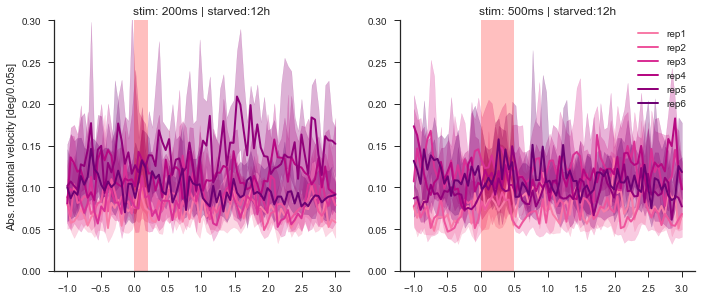

In [186]:
maxY = 0.3

fig = plt.figure(figsize=(10,4*max(len(measuredStarveLevels),2)))

for rowind, starved in enumerate(measuredStarveLevels):
    
    if starved == '0h': colMap = 'PuBu'
    elif 'Control' in genotype or 'control' in genotype: colMap = 'Greens'
    else: colMap = 'RdPu'
    cNorm  = colors.Normalize(vmin=-5, vmax=maxExpRep)
    repCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=colMap)
    
    for colind, stim in enumerate(stimLevels):
        ax = fig.add_subplot(max(len(measuredStarveLevels),2),len(stimLevels),(rowind)*len(stimLevels) + (colind+1))
        for ind, rep in enumerate(repLevels):
            rep_df = vr_df.query('exprep == "'+rep+'" and stim == "'+stim+'" and starved == "'+starved+'"')
            
            if rep_df.empty: continue

            vrPulse = rep_df['vr'].values[:maxPulseRep*len(timeAx)].reshape((maxPulseRep,len(timeAx)),order='C')
            vrMedian = np.nanmedian(vrPulse, axis=0)
            vrIQR = np.percentile(vrPulse, [25, 75], axis=0)
            
            ax.plot(timeAx, vrMedian, color=repCMap.to_rgba(ind), linewidth=2)
            ax.fill_between(timeAx, vrIQR[0,:], vrIQR[1,:], color=repCMap.to_rgba(ind), alpha=0.3, label=None)
            ax.set_ylim(0,maxY) 

        ax.set_title('stim: '+stim+' | starved:'+starved, fontsize=12)
        if rowind==1: ax.set_xlabel('Time [s]')
        if colind==0: ax.set_ylabel('Abs. rotational velocity [deg/0.05s]')     
        if colind==1: ax.legend(repLevels, loc=1)
        myAxisTheme(ax)
        
        ax.add_patch(Rectangle((0, 0), stimLevelRects[colind], maxY, facecolor='red', edgecolor='none', lw=1, alpha=0.25)) 
        
plotSaveDir = baseDir + genotype + sep + 'plots'
try:
    os.mkdir(plotSaveDir)
except OSError:
    print('Analysis folder already exists')
    
fig.tight_layout()
fig.savefig(plotSaveDir+sep+genotype+'_rot_medianIQRTriggeredAverages.pdf', format = 'pdf')